### GLM : Linear Regression

In [1]:
import json
import matplotlib
import warnings

warnings.simplefilter('ignore')

root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"] 

In [2]:
import numpy as np
# Generating some data

size = 200
true_intercept = 1
true_slope = 1

x = np.linspace(0, 1, size)

# y = a + b * X
true_regression_line = true_intercept + true_slope * x

# add some noises
y = true_regression_line + np.random.normal(scale = .5, size = size)

data = dict(x = x, y = y)

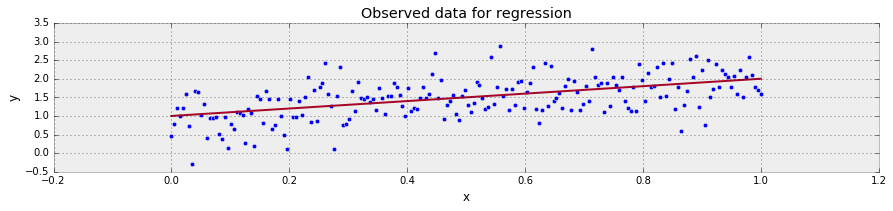

In [3]:
# Plot the data with the true regression line on it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

figsize(12.5, 3)

fig = plt.figure()
plt.title("Observed data for regression")
plt.scatter(x, y)
plt.plot(x, true_regression_line, c = colors[1])
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout();

In [4]:
import pymc3 as pm
import scipy

with pm.Model() as model:
    
    pm.glm.glm('y ~ x', data)
    
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS(scaling = start)
    trace= pm.sample(5000, step = step, start = start)
    burned_trace = trace[2500:]

Optimization terminated successfully.
         Current function value: 164.409821
         Iterations: 6
         Function evaluations: 252


100%|██████████| 5000/5000 [00:09<00:00, 553.34it/s]


In [5]:
# Interpret these result properly
pm.summary(burned_trace)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.953            0.067            0.003            [0.827, 1.086]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.821          0.909          0.953          0.997          1.084


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.059            0.113            0.005            [0.837, 1.280]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.834          0.982          1.060          1.136          1.278


sd:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

In [6]:
#pm.plots.traceplot(trace = burned_trace)
#pm.plots.autocorrplot(trace = burned_trace)

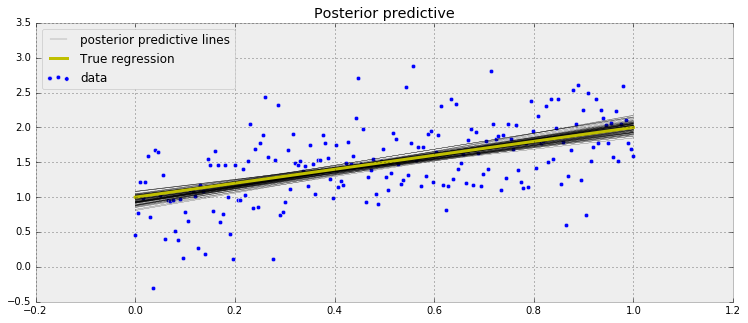

In [7]:
figsize(12.5, 5)
fig = plt.figure()
plt.title("Posterior Predictive regression lines")
plt.scatter(x, y, label = "data")
pm.glm.plot_posterior_predictive(burned_trace, samples = 100, label = "posterior predictive lines")
plt.plot(x, true_regression_line, c = 'y', label= "True regression", lw = 3)
plt.legend(loc = "upper left");

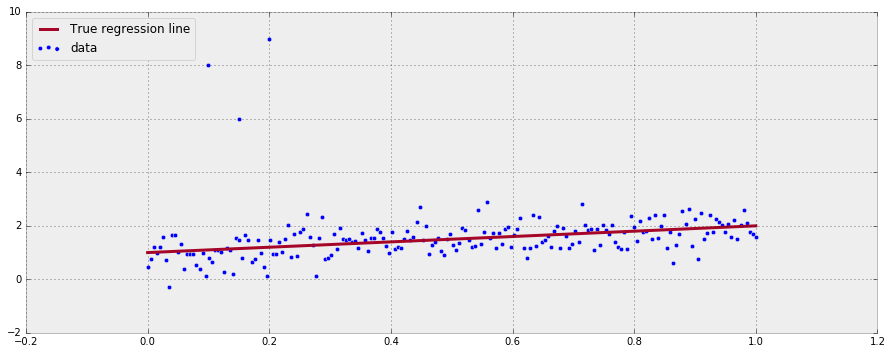

In [8]:
# Let's add some ouliers to the original data
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x = x_out, y = y_out)

#Plots
figsize(12.5, 5)
fig = plt.figure()

plt.scatter(x_out, y_out, label = "data")
plt.plot(x, true_regression_line, c = colors[1], label = "True regression line", lw = 3)
plt.legend(loc = "upper left")
plt.tight_layout()

In [9]:
with pm.Model() as model:
    pm.glm.glm('y ~ x', data)
    
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS(scaling = start)
    
    trace = pm.sample(5000, step = step, start = start)
    burned_trace = trace[2500:]

Optimization terminated successfully.
         Current function value: 303.850669
         Iterations: 6
         Function evaluations: 236


100%|██████████| 5000/5000 [00:08<00:00, 558.06it/s]


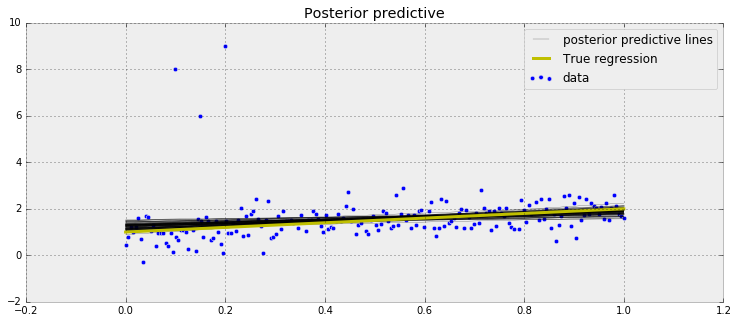

In [10]:
figsize(12.5, 5)
fig = plt.figure()
plt.title("Posterior Predictive regression lines")
plt.scatter(x_out, y_out, label = "data")
pm.glm.plot_posterior_predictive(burned_trace, samples = 100, label = "posterior predictive lines",)
plt.plot(x, true_regression_line, c = 'y', label= "True regression", lw = 3)
plt.legend(loc = "upper right");

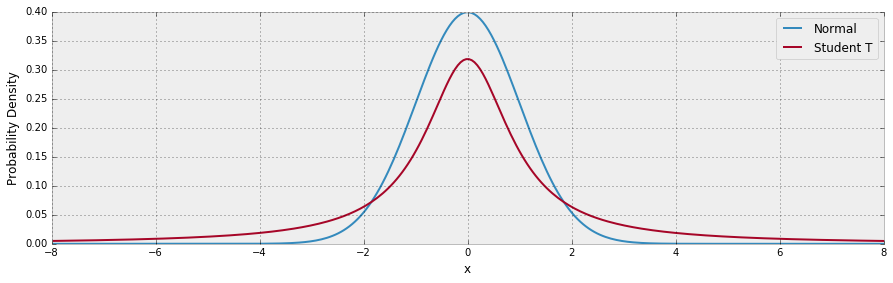

In [11]:
# The fit is skewed and we have a fair amount of uncertainty in our estimates
#as indicated by the wide range of different posterior predictive lines
#The reason is that the normal distribution does not have a lot of mass 
#in the tails and consequently an outlier will affect the fit  strongly


# Since the problem is the light tails of the Normal distribution we can instead assume that
# our data is distributed according to the Student T distribution

import theano.tensor as T

figsize(12.5, 4)

normal_dist = pm.Normal.dist(mu = 0, sd = 1)
t_dist = pm.StudentT.dist(mu = 0, lam = 1, nu = 1)
x_eval = np.linspace(-8, 8, 300)

plt.plot(x_eval, T.exp(normal_dist.logp(x_eval)).eval(), label = "Normal")
plt.plot(x_eval, T.exp(t_dist.logp(x_eval)).eval(), label = "Student T")

plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.tight_layout();

In [12]:
with pm.Model() as model:
    
    family = pm.glm.families.StudentT()
    pm.glm.glm('y ~ x', data, family = family)
    
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell)
    step = pm.NUTS()
    trace = pm.sample(5000, step = step, start = start)
    burned_trace = trace[2500:]

Optimization terminated successfully.
         Current function value: 214.226717
         Iterations: 6
         Function evaluations: 205


100%|██████████| 5000/5000 [00:18<00:00, 271.07it/s]


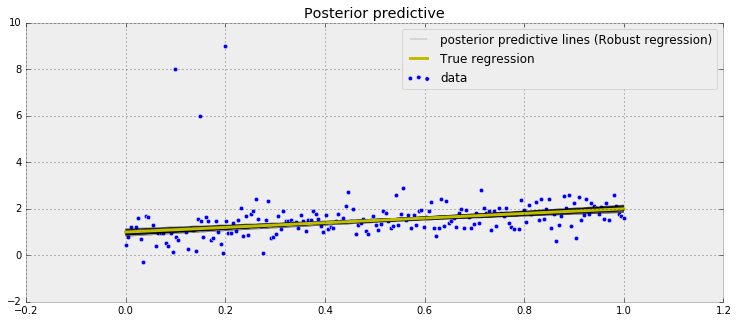

In [13]:
figsize(12.5, 5)
fig = plt.figure()
plt.title("Posterior Predictive regression lines")
plt.scatter(x_out, y_out, label = "data")
pm.glm.plot_posterior_predictive(burned_trace, samples = 100, label = "posterior predictive lines (Robust regression)")
plt.plot(x, true_regression_line, c = 'y', label= "True regression", lw = 3)
plt.legend(loc = "upper right")

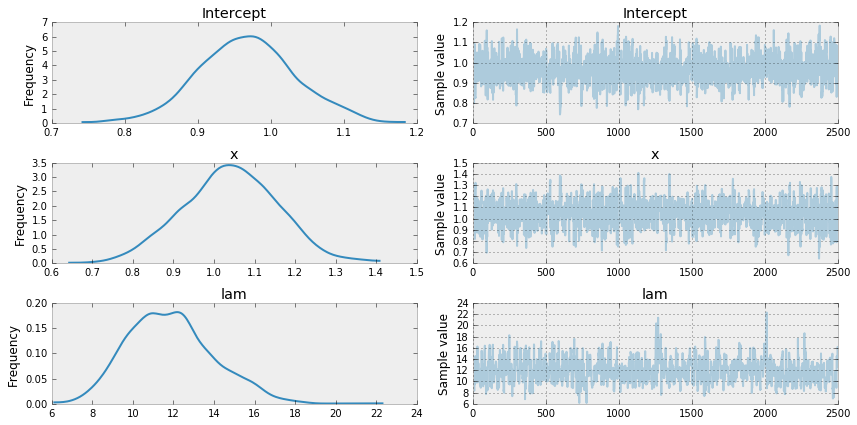

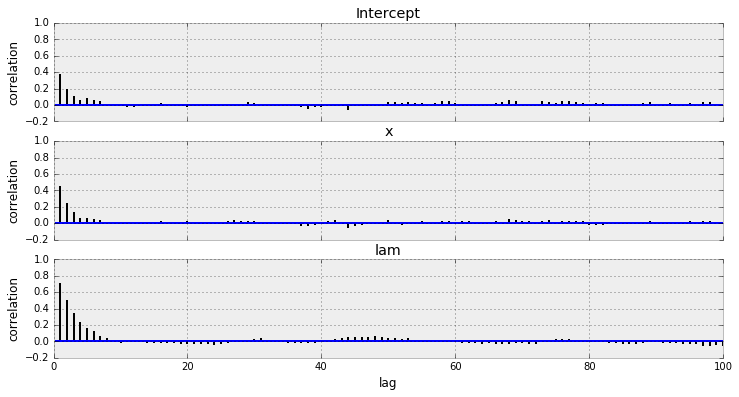

In [14]:
# pymc3 allow to pass in a family object that contains information about the likelihood
pm.plots.traceplot(trace = burned_trace)
pm.plots.autocorrplot(trace = burned_trace);

In [15]:
pm.summary(burned_trace)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.967            0.066            0.002            [0.850, 1.114]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.837          0.922          0.967          1.010          1.102


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.039            0.118            0.004            [0.799, 1.254]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.809          0.963          1.041          1.119          1.266


lam:

  Mean             SD               MC Error         95% HPD interval
  ---------------------------

### GLM : Robust regression with outliers detection

In [16]:
import pandas as pd
import theano as theano
dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


# for convenience, zero-base the id and use as index
dfhogg["id"] = dfhogg["id"] - 1
dfhogg.set_index('id', inplace = True)
dfhogg.head()

,x,y,sigma_y,sigma_x,rho_xy
id,,,,,
0.0,201.0,592.0,61.0,9.0,-0.84
1.0,244.0,401.0,25.0,4.0,0.31
2.0,47.0,583.0,38.0,11.0,0.64
3.0,287.0,402.0,15.0,7.0,-0.27
4.0,203.0,495.0,21.0,5.0,-0.33


In [17]:
# Standardize (mean, center and divide by 1 sd)

dfhoggs = (dfhogg[['x', 'y']] - dfhogg[['x', 'y']].mean(0)) / dfhogg[['x', 'y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['sigma_y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['sigma_x'].std(0)

# create xlims, ylims for plotting

xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5,
        dfhoggs['x'].max() - np.ptp(dfhoggs['x'])/5)

ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5,
        dfhoggs['y'].max() - np.ptp(dfhoggs['y'])/5)

In [18]:
#import seaborn as sns
#sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
#np.random.seed(0)


# Seaborn scatter plots

#g = sns.FacetGrid(dfhoggs, size = 12)
#_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker = "o", ls = '')
#_ = g.axes[0][0].set_ylim(ylims)
#_ = g.axes[0][0].set_xlim(xlims)

#plt.subplots_adjust(top = 0.92)
#_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize = 13)

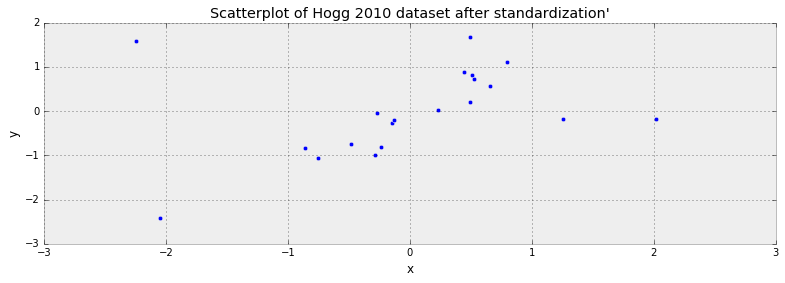

In [19]:
figsize(11, 4)
plt.title("Scatterplot of Hogg 2010 dataset after standardization'")
plt.scatter(dfhoggs['x'], dfhoggs['y'])
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

In [20]:
with pm.Model() as model_OLS:
    
    # define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal("b0", mu = 0, sd = 100)
    b1 = pm.Normal("b1", mu = 0, sd = 100)
    
    # define a linear model
    yest = b0 + b1*dfhoggs['x']
    
    # use y error from dataset, convert into theano variable
    sigma_y = theano.shared(np.asarray(dfhoggs['sigma_y'],
                                      dtype = theano.config.floatX), name = 'sigma_y')
    
    Likelihood = pm.Normal('obs', mu = yest, sd = sigma_y, observed = dfhoggs['y'])

In [21]:
with model_OLS:
    
    start  = pm.find_MAP(fmin = scipy.optimize.fmin_powell, disp = True)
    step = pm.NUTS(scaling = start)
    
    trace_OLS = pm.sample(5000, step = step, start = start)
    burned_OLS = trace_OLS[3000:]

Optimization terminated successfully.
         Current function value: 44.289075
         Iterations: 2
         Function evaluations: 38


100%|██████████| 5000/5000 [00:02<00:00, 1834.93it/s]


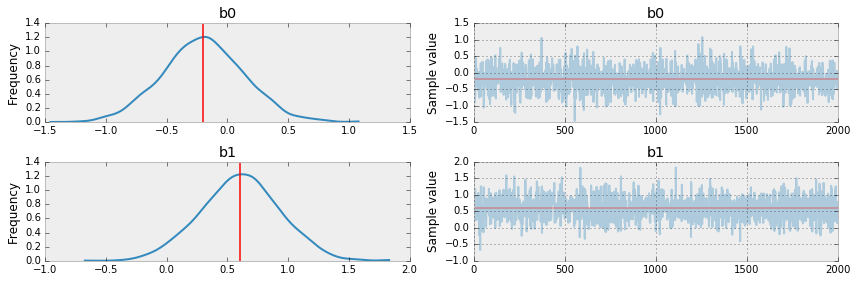

In [22]:
pm.plots.traceplot(trace = burned_OLS,
                  lines = {k: v['mean'] for k, v in pm.df_summary(burned_OLS).iterrows()});

In [23]:
with pm.Model() as model_StudentT:
    
    # define weakly informative Normal priors to give Ridgne regression
    b0 = pm.Normal("b0", mu = 0, sd = 100)
    b1 = pm.Normal("b1", mu = 0, sd = 100)
    
    #Define the linear model
    yest = b0 + b1*dfhoggs['x']
    
    # Use y error from dataset convert into theano variable
    sigma_y = theano.shared(np.asarray(dfhoggs['sigma_y'],
                                      dtype = theano.config.floatX), name = 'sigma_Y')
    
    # Define prior dor Student T degrees of freedom
    nu = pm.DiscreteUniform('nu', lower = 1, upper = 100)
    
    # Define the StudentT likelihood
    likehood = pm.StudentT("obs", mu = yest, sd = sigma_y, nu = nu, observed = dfhoggs['y'])

In [24]:
with model_StudentT:
    
    start = pm.find_MAP(fmin = scipy.optimize.fmin_powell, disp = True)
    step1 = pm.NUTS(vars = [b0, b1])
    step2 = pm.Metropolis(vars = [nu])
    
    trace_StudentT = pm.sample(5000, step = [step1, step2], start = start)
    burned_StudentT = trace_StudentT[3000:]

Optimization terminated successfully.
         Current function value: 49.026473
         Iterations: 2
         Function evaluations: 39


100%|██████████| 5000/5000 [00:03<00:00, 1304.88it/s]


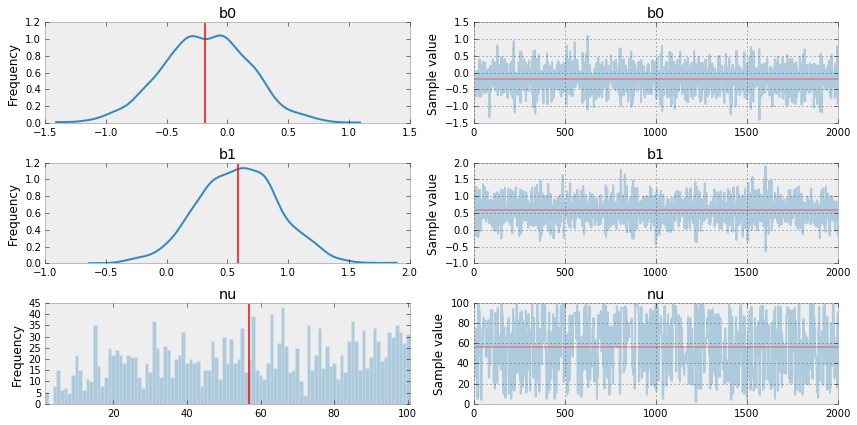

In [25]:
pm.plots.traceplot(trace = burned_StudentT, 
                   lines = {k: v['mean'] for k, v in pm.df_summary(burned_StudentT).iterrows()});

In [26]:
#pm.plots.autocorrplot(trace = burned_StudentT)

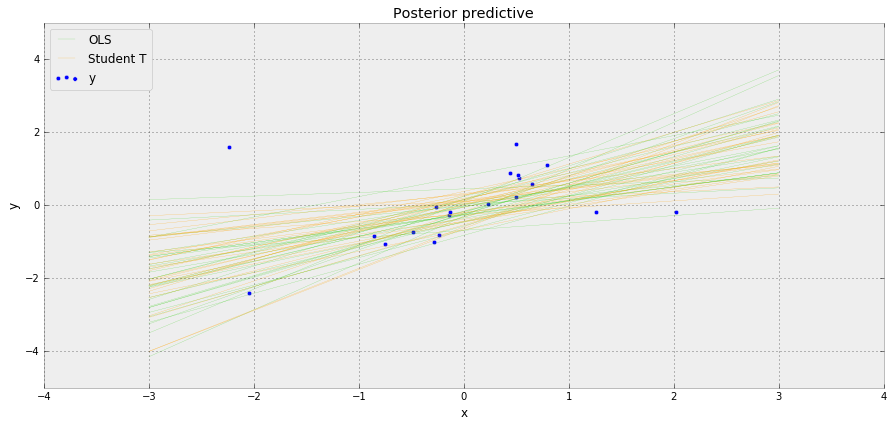

In [35]:
figsize(12.5, 6)
lm = lambda x, samp: samp['b0'] + samp['b1'] * x
plt.title("Scatterplot of Hogg 2010 dataset after standardization'")
plt.scatter(dfhoggs['x'], dfhoggs['y'])
pm.glm.plot_posterior_predictive(burned_OLS, eval=np.linspace(-3, 3, 10), 
                                lm = lm,  color='#22CC00', alpha=.7, label = 'OLS')
pm.glm.plot_posterior_predictive(burned_StudentT, eval=np.linspace(-3, 3, 10),
                                 lm = lm, color='#FFA500', alpha=.9, label = 'Student T')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc = "upper left")
plt.tight_layout();

In [41]:
print(pm.summary(burned_StudentT))
print(pm.summary(burned_OLS));


b0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.182           0.358            0.009            [-0.954, 0.455]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.898         -0.422         -0.175         0.063          0.528


b1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.588            0.334            0.009            [-0.033, 1.248]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.054         0.355          0.594          0.810          1.240


nu:

  Mean             SD               MC Error         95% HPD interval
  --------------------------------

Event if the StudentT regression capture more the outlier, it seems that the OLS have on parameter a more lower error